# Glauber dynamics of the Random Field Ising model 

Compare with results in [Vázquez, Eduardo Domínguez, Gino Del Ferraro, and Federico Ricci-Tersenghi. "A simple analytical description of the non-stationary dynamics in Ising spin systems." Journal of Statistical Mechanics: Theory and Experiment 2017.3 (2017)](https://www.doi.org/10.1088/1742-5468/aa5d22)

In [ ]:
using MatrixProductBP, MatrixProductBP.Models
using Distributions, Statistics, Base.Threads, Plots, LaTeXStrings, Random
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2
import Measurements: value
using Graphs, IndexedGraphs
import MatrixProductBP.AtomicVector;

In [ ]:
include("../../telegram/notifications.jl");

In [ ]:
T = 30     # final time
c = 3      # mean connectivity of Erdos-Renyi graph

J = 1/c    # coupling
β = 1/0.5  # inverse temperature
h = 0.3    # external field 
m⁰ = 1.0;  # magnetization at time zero

popsize = 10^3              # population size
svd_trunc = TruncBond(10);  # SVD truncator

In [ ]:
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
ψ_neutral = [ones(2,2) for t in 0:T];

In [ ]:
seed = 1
N = 5*10^3
g = erdos_renyi(N, c/N; seed)
rng = MersenneTwister(seed)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=h*rand(rng, (-1,1), N), β)
sms = SoftMarginSampler(mpbp(Glauber(ising, T); ϕ=fill(ϕᵢ, N)));

In [ ]:
sample!(sms, 5*10^3)
m_mc = [value.(expectation.(spin, b)) for b in marginals(sms)];

In [30]:
m_eq = equilibrium_magnetization(ErdosRenyi(c); pJ=Dirac(J), β, ph, popsize=2*10^6,
        maxiter=10^2, tol=1e-6, nsamples=10^4);

Running PopDyn: iter 100 	 Time: 0:03:40
  it:  100/100
  ε:   1.182064/1.0e-6┌ Warning: Population dynamics did not converge. Error 1.182063596218219
└ @ MatrixProductBP.Models /home/crotti/MatrixProductBP/src/Models/glauber/equilibrium.jl:105


In [ ]:
function onebpiter_inner(μ, wᵢ, dᵢ, ns, ϕᵢ, ψ, T, svd_trunc)
    C, full, logzᵢ = MatrixProductBP.Models.compute_prob_ys(wᵢ, ns, μ, ψ, T, svd_trunc)
    for j in 1:dᵢ
        B = MatrixProductBP.Models.f_bp_partial_ij(C[j], wᵢ, ϕᵢ, dᵢ - 1, ns, j)
        μ[j] = sweep_RtoL!(mpem2(B); svd_trunc)
        logzᵢ += normalize!(μ[j])
    end
    B = MatrixProductBP.Models.f_bp_partial_i(full, wᵢ, ϕᵢ, dᵢ)
    b = B |> mpem2 |> marginalize
    f = dᵢ == 0 ? 0.0 : -logzᵢ / dᵢ
    return μ, b, f
end

In [ ]:
function iterate_population!(P, bs, btus, J, β, ph, degree_prob, ϕᵢ, T, svd_trunc; nsamples=2*10^2)
    Lb = length(bs); Lbtus = length(btus)
    resize!(bs, Lb + nsamples); resize!(btus, Lbtus + nsamples)
    prog = Progress(nsamples)
    @threads for n in 1:nsamples
        d = rand(degree_prob)
        h = rand(ph)
        wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
        d > popsize && error("Sampled degree $d greater than population size $popsize")
        indices = rand(eachindex(P), d)     
        μ, b, f = onebpiter_inner(P[indices], wᵢ, d, 2, ϕᵢ, fill(ψ_neutral, d), T, svd_trunc)
        P[indices] = μ
        bs[Lb + n] = marginals(b)
        btus[Lbtus + n] = marginals_tu(b)
        next!(prog)
    end
end

In [ ]:
degree_prob = Poisson(c)
ph = MixtureModel(Dirac, [-h, h])
P = map(1:popsize) do p
    μ = rand_mpem2(2, 2, T)
    normalize!(μ)
    μ
end |> AtomicVector
bs = Vector{Vector{Float64}}[]
btus =  Matrix{Matrix{Float64}}[];

In [ ]:
@telegram "RFIM infinite 1/4" begin
    iterate_population!(P, bs, btus, J, β, ph, degree_prob, ϕᵢ, T, svd_trunc; nsamples=3*10^3);
end;

In [ ]:
spin(x) = 3 - 2x
# take the average beliefs over the last `ns` iterations
ns = 2000
range = length(bs)+1-min(ns, length(bs)):length(bs)
ms1 = [expectation.(spin, b) for b in bs[range]]
m_avg1 = mean(ms1)
m_std1 = std(ms1) ./ sqrt(length(ms1));

In [ ]:
pl = plot(0:length(m_avg1)-1, m_avg1, lw=3, ribbon=m_std1, xlabel="time", ylabel="magnetiz",
    size = (600,300), label="MPBP")
scatter!(pl, 0:length(mean(m_mc))-1, mean(m_mc), label="MC", c=:black, m=:diamond)
hline!(pl, [m_eq.val], label="equilibrium", c=:red, ls=:dash, lw=1, size=(600,300)#=, ribbon=[-m_eq.err]=#)

In [ ]:
@telegram "RFIM infinite 2/4" begin
    iterate_population!(P, bs, btus, J, β, ph, degree_prob, ϕᵢ, T, svd_trunc; nsamples=10*10^3);
end;

In [ ]:
spin(x) = 3 - 2x
# take the average beliefs over the last `ns` iterations
ns = 10000
range = length(bs)+1-min(ns, length(bs)):length(bs)
ms2 = [expectation.(spin, b) for b in bs[range]]
m_avg2 = mean(ms2)
m_std2 = std(ms2) ./ sqrt(length(ms2));

In [ ]:
pl = plot(0:length(m_avg2)-1, m_avg2, lw=3, ribbon=m_std2, xlabel="time", ylabel="magnetiz",
    size = (600,300), label="MPBP")
scatter!(pl, 0:length(mean(m_mc))-1, mean(m_mc), label="MC", c=:black, m=:diamond)
hline!(pl, [m_eq.val], label="equilibrium", c=:red, ls=:dash, lw=1, size=(600,300)#=, ribbon=[-m_eq.err]=#)

In [ ]:
@telegram "RFIM infinite 3/4" begin
    iterate_population!(P, bs, btus, J, β, ph, degree_prob, ϕᵢ, T, svd_trunc; nsamples=10*10^3);
end;

In [ ]:
spin(x) = 3 - 2x
# take the average beliefs over the last `ns` iterations
ns = 10000
range = length(bs)+1-min(ns, length(bs)):length(bs)
ms3 = [expectation.(spin, b) for b in bs[range]]
m_avg3 = mean(ms3)
m_std3 = std(ms3) ./ sqrt(length(ms3));

In [ ]:
pl = plot(0:length(m_avg3)-1, m_avg3, lw=3, ribbon=m_std3, xlabel="time", ylabel="magnetiz",
    size = (600,300), label="MPBP")
scatter!(pl, 0:length(mean(m_mc))-1, mean(m_mc), label="MC", c=:black, m=:diamond)
hline!(pl, [m_eq.val], label="equilibrium", c=:red, ls=:dash, lw=1, size=(600,300)#=, ribbon=[-m_eq.err]=#)

In [ ]:
@telegram "RFIM infinite 4/4" begin
    iterate_population!(P, bs, btus, J, β, ph, degree_prob, ϕᵢ, T, svd_trunc; nsamples=7*10^3);
end;

In [39]:
spin(x) = 3 - 2x
# take the average beliefs over the last `ns` iterations
ns = 1000
range = length(bs)+1-min(ns, length(bs)):length(bs)
ms4 = [expectation.(spin, b) for b in bs[range]]
m_avg4 = mean(ms4)
m_std4 = std(ms4) ./ sqrt(length(ms4));

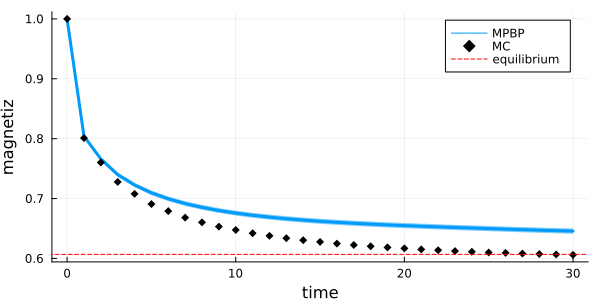

In [40]:
pl = plot(0:length(m_avg4)-1, m_avg4, lw=3, ribbon=m_std3, xlabel="time", ylabel="magnetiz",
    size = (600,300), label="MPBP")
scatter!(pl, 0:length(mean(m_mc))-1, mean(m_mc), label="MC", c=:black, m=:diamond)
hline!(pl, [m_eq.val], label="equilibrium", c=:red, ls=:dash, lw=1, size=(600,300)#=, ribbon=[-m_eq.err]=#)

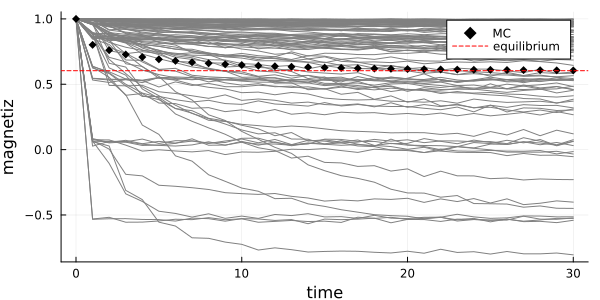

In [165]:
ns = 100
range = length(bs)+1-min(ns, length(bs)):length(bs)
ms3 = [expectation.(spin, b) for b in bs[range]]

pl = plot(0:length(m_avg3)-1, m_mc[1:100], lw=1, xlabel="time", ylabel="magnetiz",
    size = (600,300), label="", c=:gray)
scatter!(pl, 0:length(mean(m_mc))-1, mean(m_mc), label="MC", c=:black, m=:diamond)
hline!(pl, [m_eq.val], label="equilibrium", c=:red, ls=:dash, lw=1, size=(600,300)#=, ribbon=[-m_eq.err]=#)

In [41]:
rs = [expectation.(spin, btu) for btu in btus[range]]
cs = MatrixProductBP.covariance.(rs, ms4)
c_avg = mean(cs)
c_std = std(cs) ./ sqrt(length(cs));

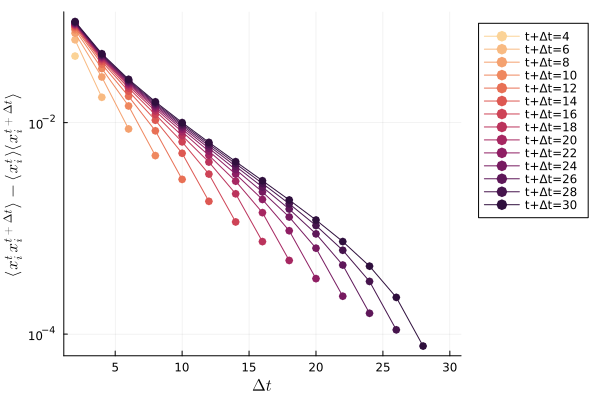

In [42]:
plot_autocovs(args...; kw...) = plot_autocovs!(plot(), args...; kw...)
function plot_autocovs!(pl, c; skip_even=false, T=size(c,1)-1, us = 0:(2*floor(Int, T/10)):T, kw...)
    step = skip_even ? 2 : 1
    cg = cgrad(:matter, length(us)+1, categorical=true)
    ylabel = L"\langle x_{i}^t x_{i}^{t+\Delta t}\rangle-" * 
        L"\langle x_{i}^t\rangle\langle x_{i}^{t+\Delta t}\rangle"
    xlabel = L"\Delta t"
    plot!(pl; xlabel, ylabel, legend=:outertopright)
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-step:1, c[(0:step:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j+1], msc=:auto; kw...) 
    end
    pl
end 

cc = [x > 1e-14 ? x : NaN for x in c_avg]
plot_autocovs(cc; skip_even=true, yaxis=:log10, m=:o, us=4:2:T)

In [122]:
m = mean(ms2)
jldsave("plot_data/glauber_RFIM_infinite.jld2"; T, m_eq, m_mc, m, c, c_avg);